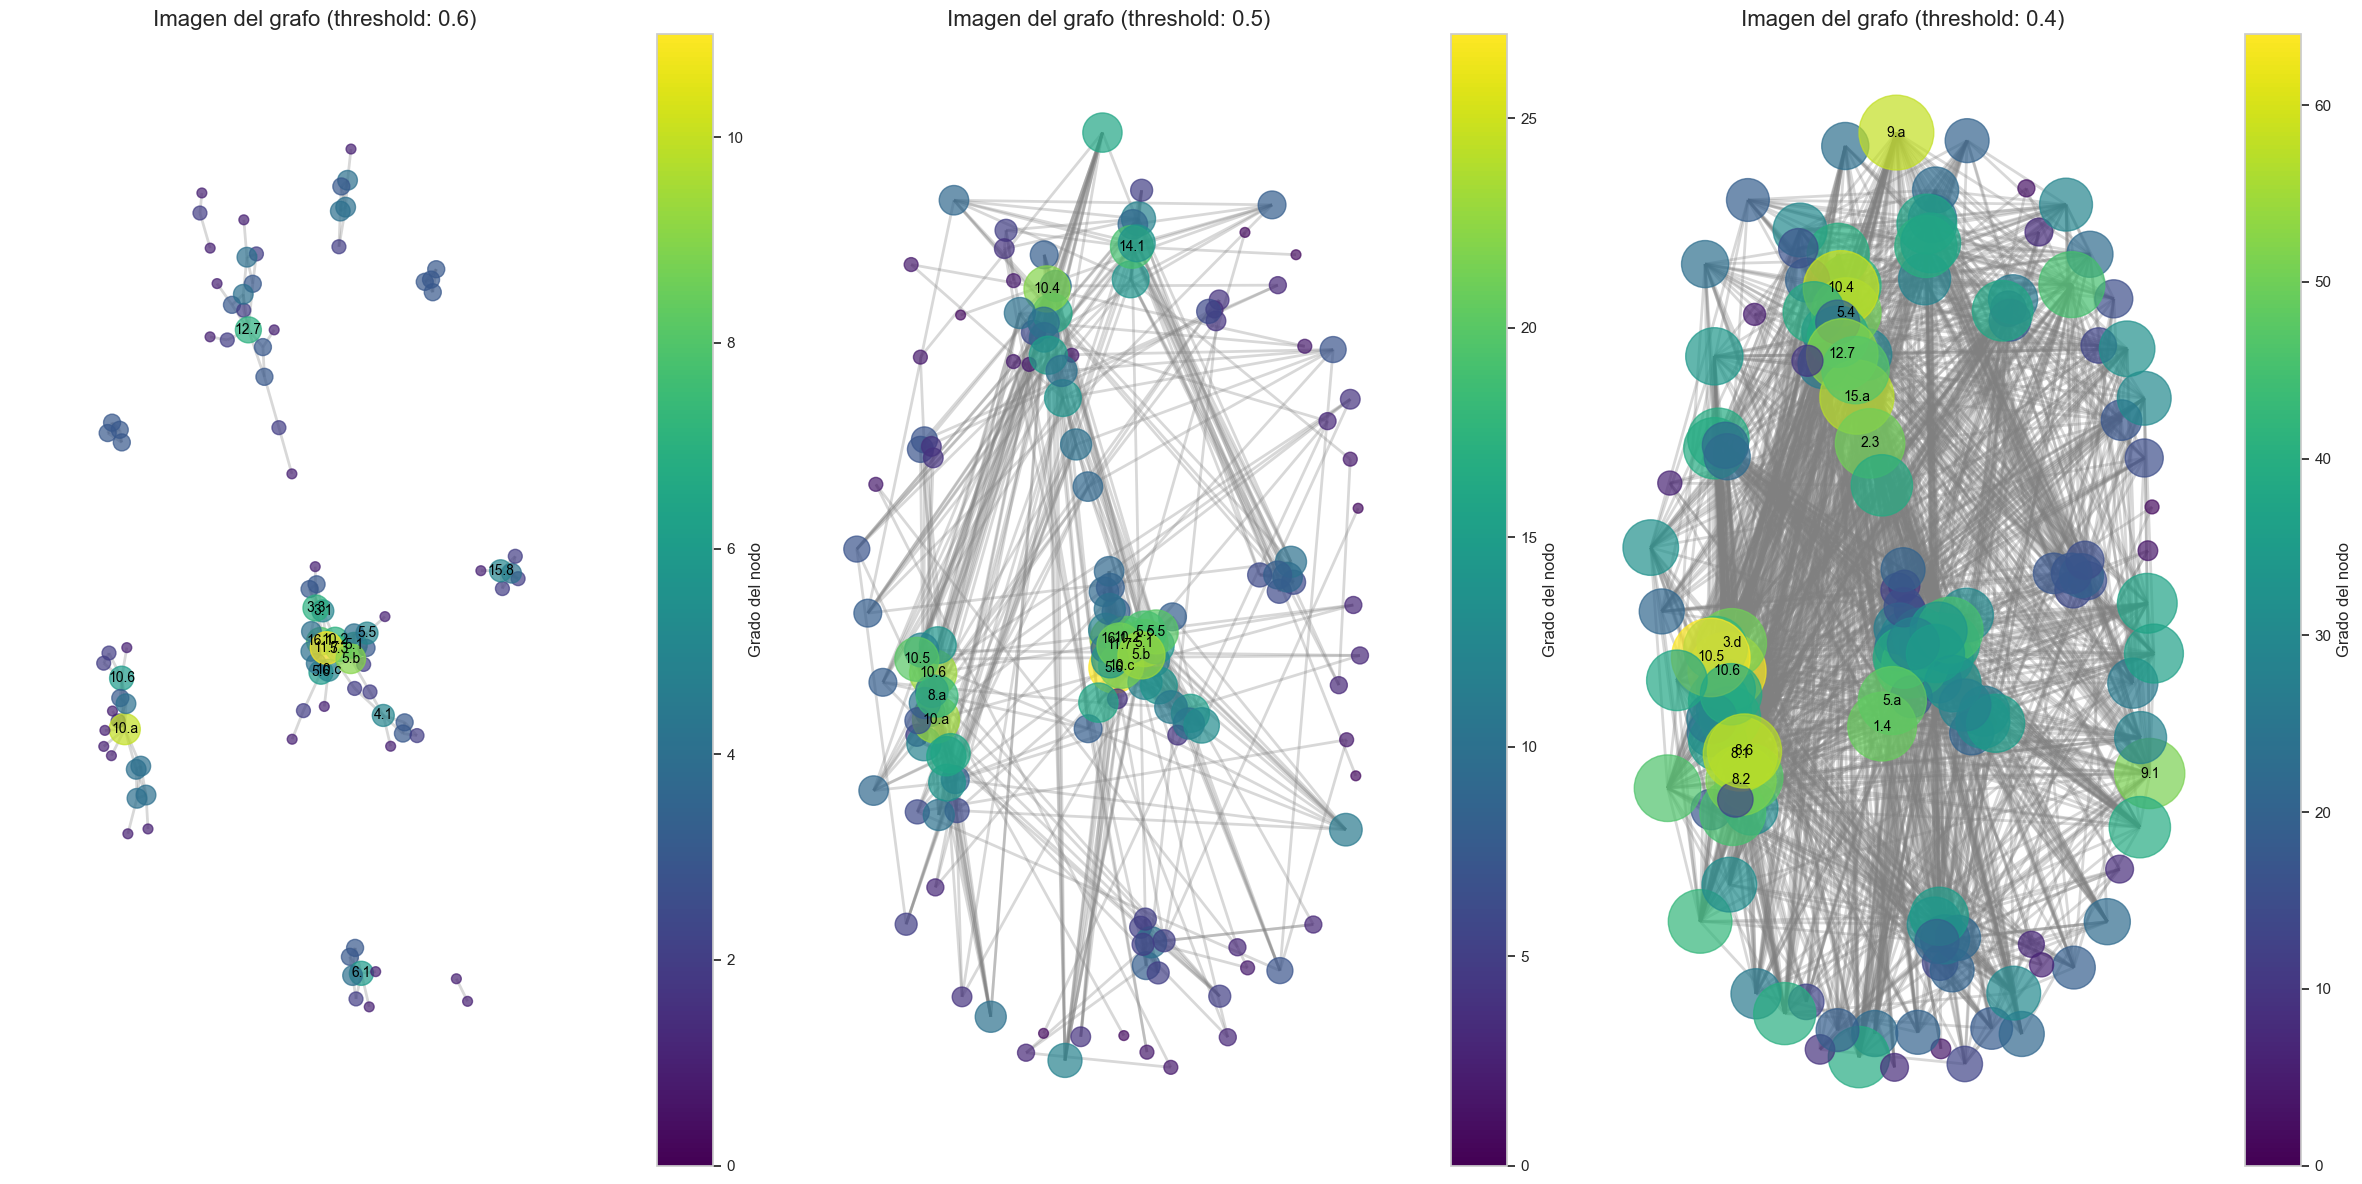

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # Para mejorar la estética de los gráficos
import re  # Para expresiones regulares

# Configuración de estilo de Seaborn para mejores gráficos
sns.set(style="whitegrid")

# ==========================================
# Paso 1: Cargar la matriz de similitud desde el archivo CSV
# ==========================================
df = pd.read_csv('data/nuevo_dataframe.csv', index_col=0)

# ==========================================
# Paso 1.1: Filtrar nodos que pertenecen al objetivo 17
# ==========================================
# Definir el patrón para los nodos a eliminar
patron = r'^17\.[A-Za-z0-9]'

# Identificar los nodos que coinciden con el patrón
nodos_a_eliminar = df.index[df.index.str.match(patron)]

# Eliminar los nodos de las filas y columnas
df = df.drop(nodos_a_eliminar, axis=0)
df = df.drop(nodos_a_eliminar, axis=1)

# ==========================================
# Paso 2: Definir los umbrales con claves numéricas
# ==========================================
thresholds = {
    1: 0.4,
    2: 0.5,
    3: 0.6
}

# Ordenar los umbrales de mayor a menor para revertir el orden de los plots
thresholds_ordenados = dict(sorted(thresholds.items(), key=lambda item: item[1], reverse=True))

# Nombre del grafo
nombre_grafo = "Imagen del grafo"

# ==========================================
# Paso 3: Crear los grafos para cada umbral
# ==========================================
grafos = {}
for clave, umbral in thresholds_ordenados.items():
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos
    G.add_nodes_from(df.index)
    
    # Añadir aristas basadas en el umbral
    # Iterar sobre la matriz de similitud
    for i in df.index:
        for j in df.columns:
            if i != j:
                similitud = df.at[i, j]
                if similitud >= umbral:
                    G.add_edge(i, j, weight=1)
    
    grafos[clave] = G

# ==========================================
# Paso 4: Definir una posición para los nodos
# ==========================================
# Usaremos un layout que distribuye mejor los nodos en grafos grandes
# Usamos el primer grafo (mayor umbral) para definir las posiciones
pos = nx.spring_layout(grafos[next(iter(grafos))], seed=42, k=0.1, iterations=50)

# ==========================================
# Paso 5: Configurar la figura para contener los subgráficos de los grafos
# ==========================================
fig_grafos, axes_grafos = plt.subplots(1, 3, figsize=(24, 12))

# ==========================================
# Paso 6: Dibujar cada grafo en su propio subgráfico
# ==========================================
for ax, (clave, G) in zip(axes_grafos, grafos.items()):
    # Calcular el grado de cada nodo
    grados = dict(G.degree())
    
    # Normalizar los grados para el tamaño de los nodos
    node_sizes = [v * 50 for v in grados.values()]
    
    # Dibujar nodos
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_sizes,
        node_color=list(grados.values()),
        cmap=plt.cm.viridis,
        alpha=0.7
    )
    
    # Dibujar aristas
    edges = G.edges(data=True)
    # Normalizar los pesos para el grosor de las aristas
    edge_widths = [edata['weight'] * 2 for _, _, edata in edges]
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edgelist=edges,
        width=edge_widths,
        alpha=0.3,
        edge_color='gray'
    )
    
    # Añadir una barra de colores para los nodos
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(grados.values()), vmax=max(grados.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Grado del nodo')
    
    # Mostrar etiquetas solo para nodos con grado alto (percentil 90)
    umbral_grado = pd.Series(grados).quantile(0.9)
    etiquetas = {n: n for n, d in grados.items() if d >= umbral_grado}
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        labels=etiquetas,
        font_size=10,
        font_color='black'
    )
    
    # Título del subgráfico con el formato deseado
    ax.set_title(f'{nombre_grafo} (threshold: {thresholds_ordenados[clave]})', fontsize=16)
    
    # Eliminar los ejes
    ax.set_axis_off()

# Ajustar el layout y mostrar la figura de los grafos
plt.tight_layout()
plt.show()


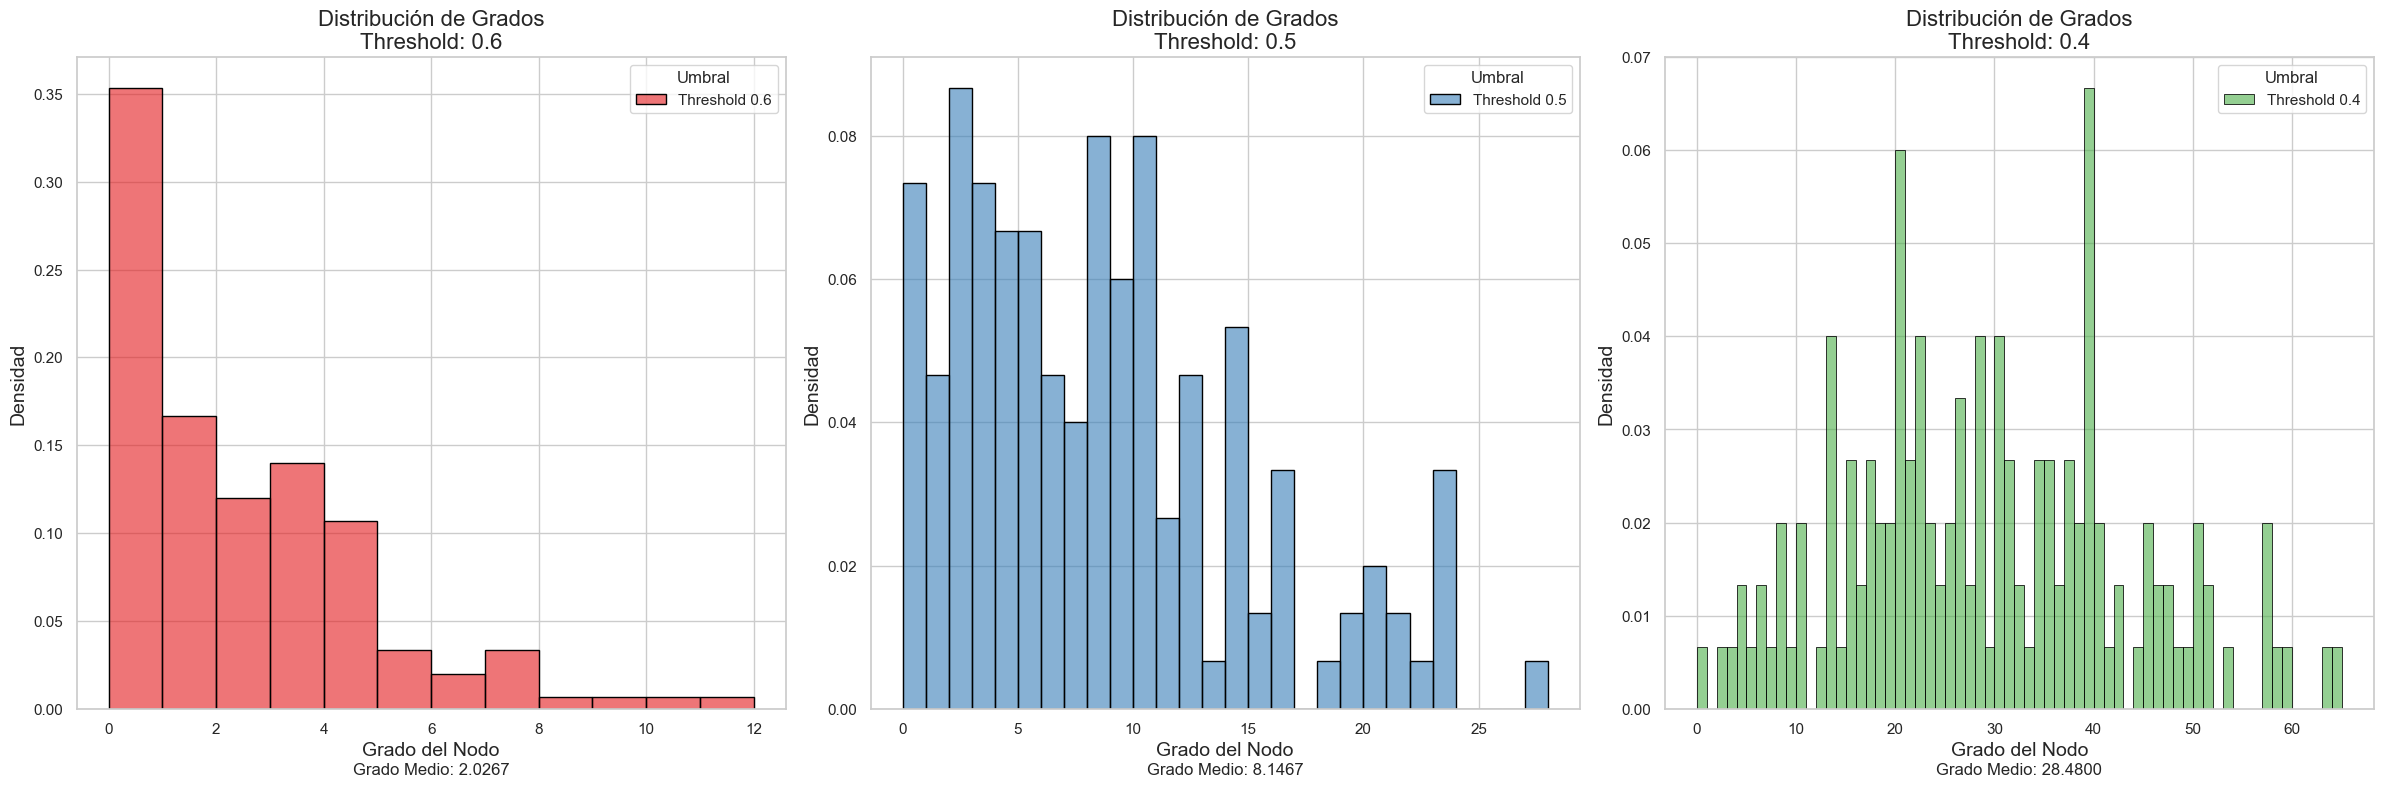

In [19]:
# Crear una nueva figura para la distribución de grados con 3 subgráficos
fig_grados, axes_grados = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de grados
for idx, (clave, G) in enumerate(grafos.items()):
    grados = [degree for node, degree in G.degree()]
    
    # Calcular el grado medio
    grado_medio = sum(grados) / len(grados) if grados else 0
    
    # Plotear el histograma de grados en su propio subgráfico
    sns.histplot(
        grados, bins=range(min(grados), max(grados) + 2),
        kde=False, stat="density", label=f'Threshold {thresholds[clave]}',
        color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_grados[idx]
    )
    
    # Añadir título y etiquetas a cada subgráfico
    axes_grados[idx].set_title(
        f'Distribución de Grados\nThreshold: {thresholds[clave]}',
        fontsize=16
    )
    axes_grados[idx].set_xlabel('Grado del Nodo', fontsize=14)
    axes_grados[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda y subtítulo con el grado medio
    axes_grados[idx].legend(title='Umbral')
    axes_grados[idx].text(
        0.5, -0.1, f'Grado Medio: {grado_medio:.4f}',
        fontsize=12, ha='center', transform=axes_grados[idx].transAxes
    )

# Ajustar el layout y mostrar la figura de la distribución de grados
plt.tight_layout()
plt.show()


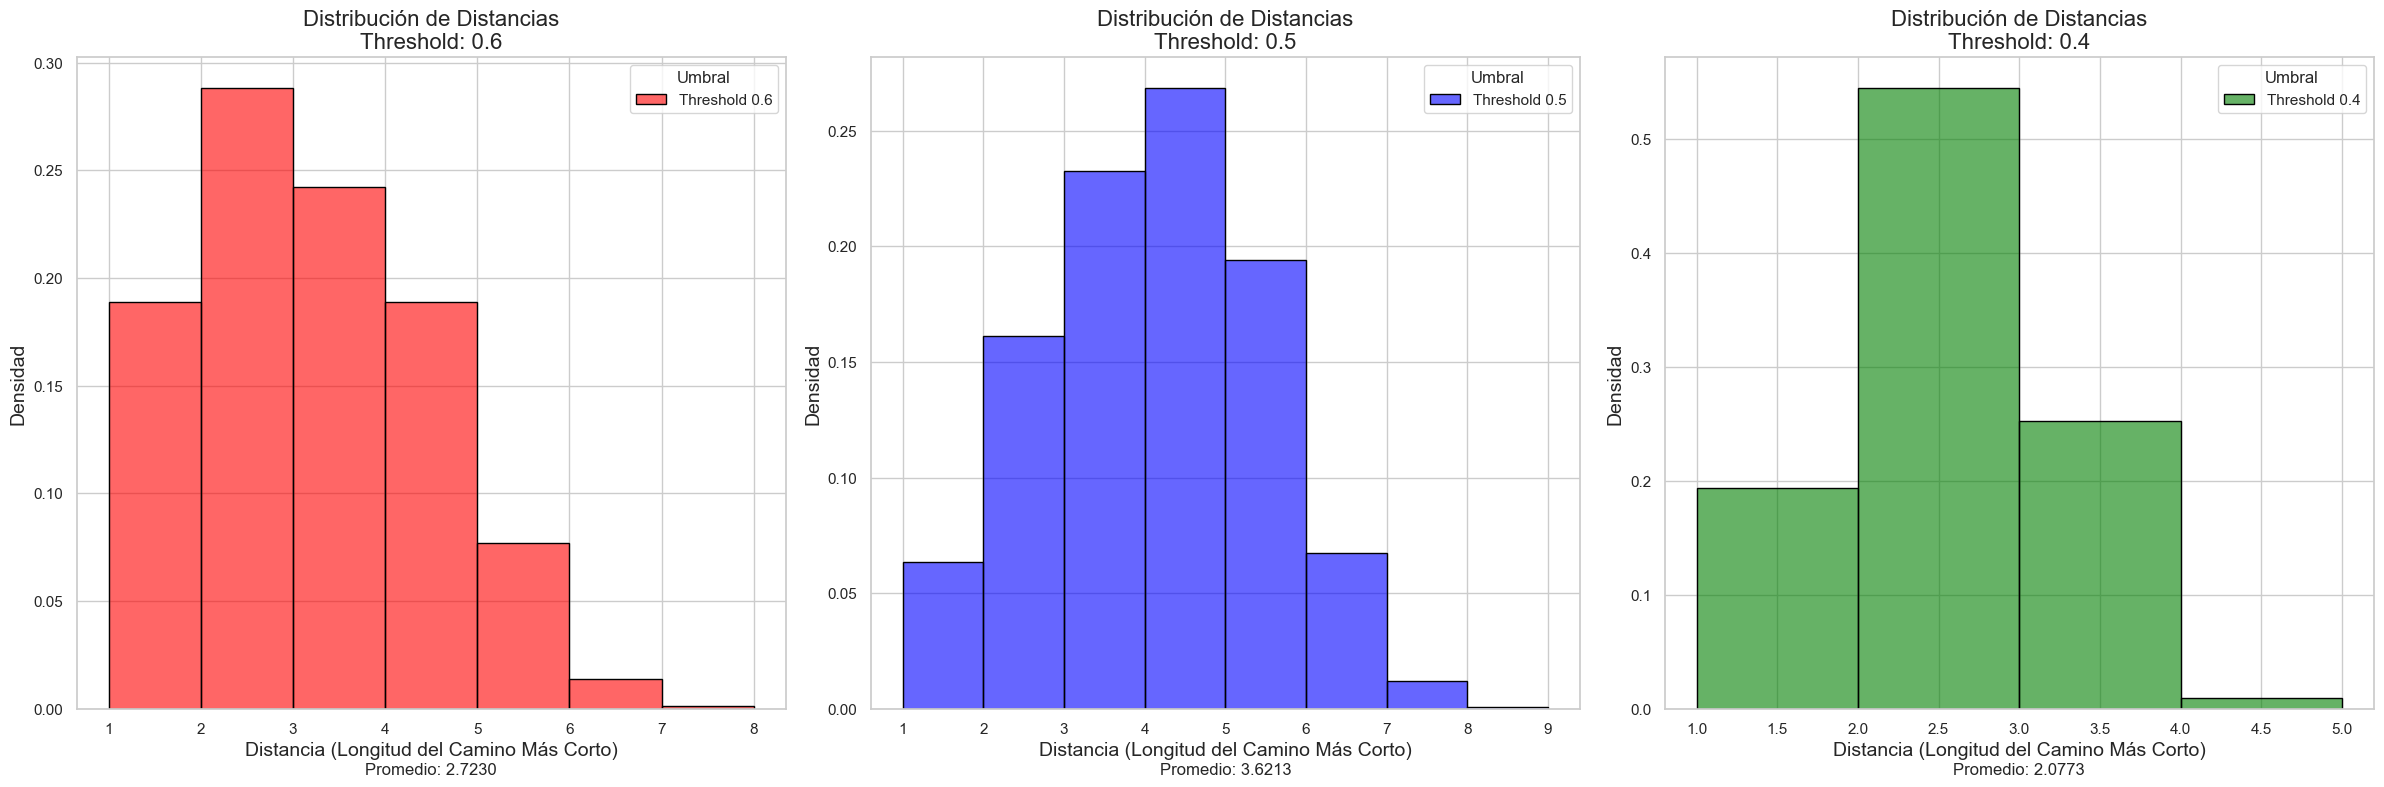

In [17]:
# Crear una nueva figura para la distribución de distancias con 3 subgráficos
fig_distancias, axes_distancias = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de distancias
for idx, (clave, G) in enumerate(grafos.items()):
    # Verificar si el grafo está conectado
    if nx.is_connected(G):
        # Si está conectado, calcular todas las distancias
        distancias = []
        for source, lengths in nx.all_pairs_shortest_path_length(G):
            distancias.extend(lengths.values())
    else:
        # Si no está conectado, calcular distancias solo en componentes conectados
        distancias = []
        for component in nx.connected_components(G):
            subgraph = G.subgraph(component)
            for source, lengths in nx.all_pairs_shortest_path_length(subgraph):
                distancias.extend(lengths.values())
    
    # Remover distancias de 0 (distancia de un nodo a sí mismo)
    distancias = [d for d in distancias if d > 0]
    
    # Calcular la distancia promedio
    distancia_promedio = sum(distancias) / len(distancias) if distancias else 0

    # Convertir a una serie de pandas para facilitar el manejo
    distancias_series = pd.Series(distancias)
    
    # Plotear el histograma de distancias en su propio subgráfico
    sns.histplot(
        distancias_series, bins=range(1, distancias_series.max() + 2),
        kde=False, stat="density", label=f'Threshold {thresholds[clave]}',
        color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_distancias[idx]
    )
    
    # Añadir título y etiquetas a cada subgráfico
    axes_distancias[idx].set_title(
        f'Distribución de Distancias\nThreshold: {thresholds[clave]}',
        fontsize=16
    )
    axes_distancias[idx].set_xlabel('Distancia (Longitud del Camino Más Corto)', fontsize=14)
    axes_distancias[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda y subtítulo con la distancia promedio
    axes_distancias[idx].legend(title='Umbral')
    axes_distancias[idx].text(
        0.5, -0.1, f'Promedio: {distancia_promedio:.4f}',
        fontsize=12, ha='center', transform=axes_distancias[idx].transAxes
    )

# Ajustar el layout y mostrar la figura de la distribución de distancias
plt.tight_layout()
plt.show()


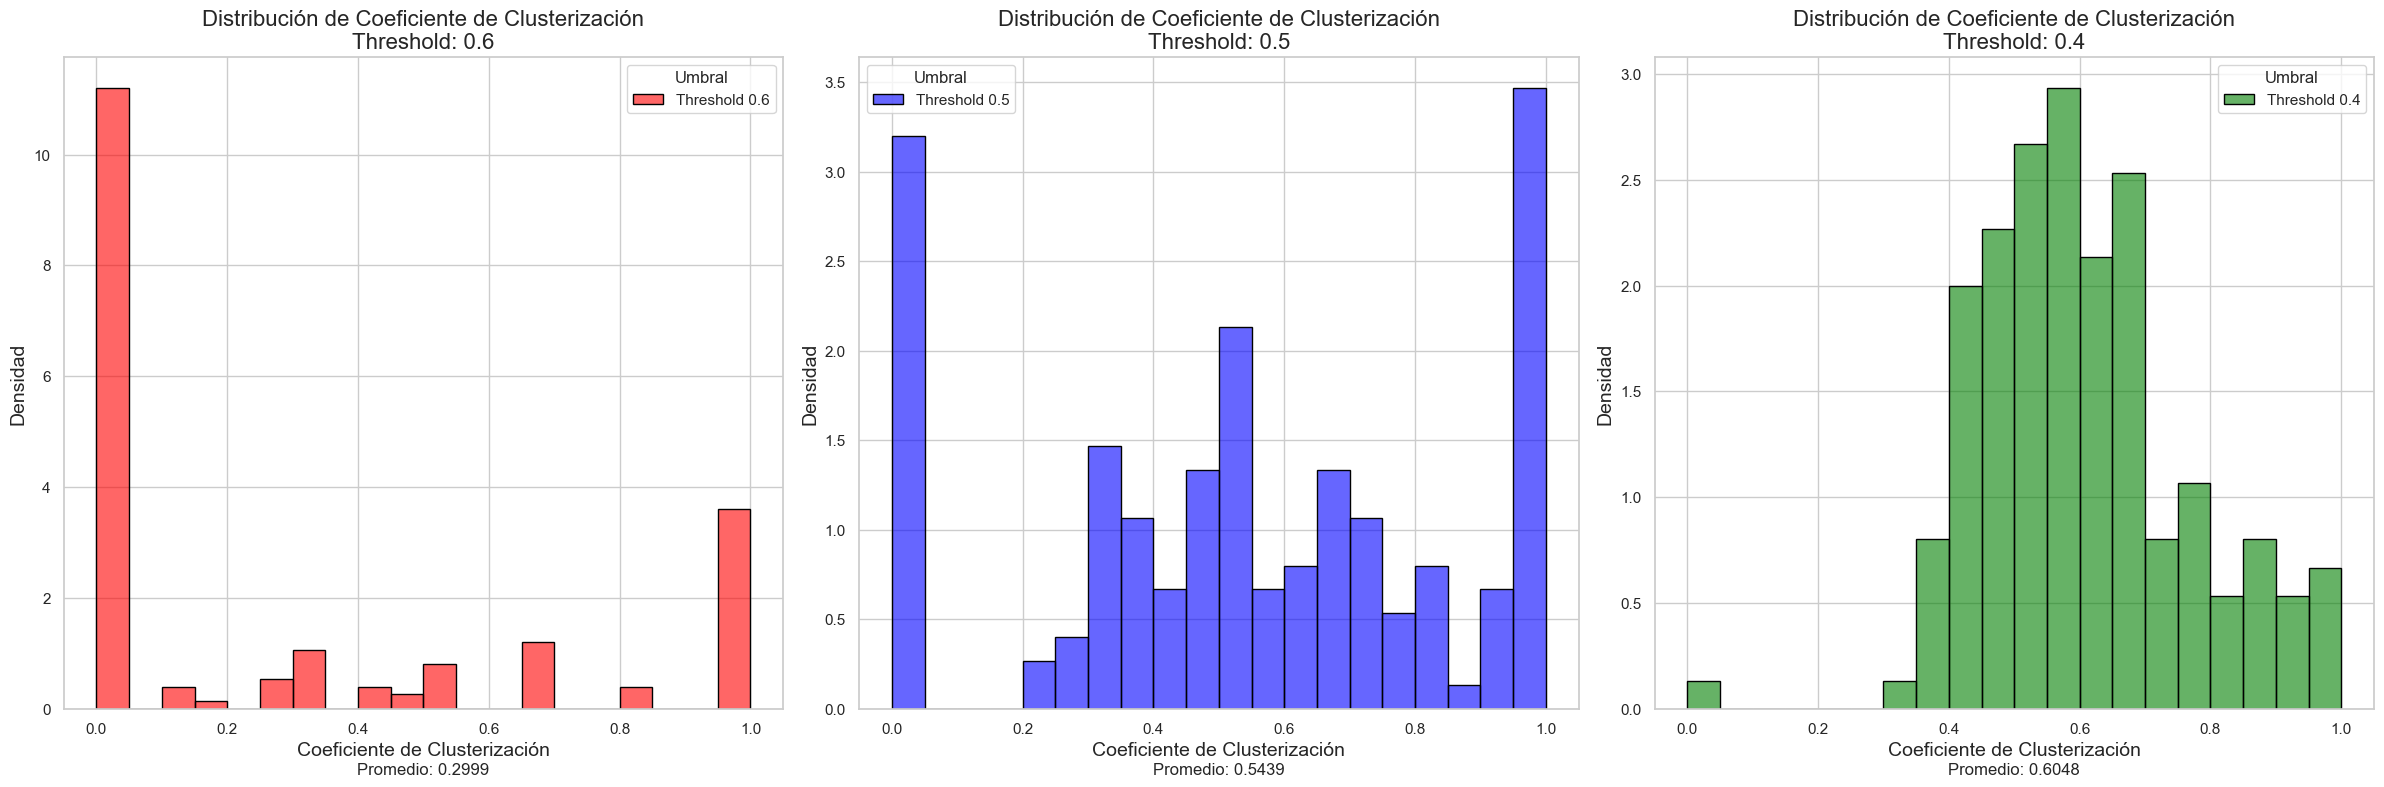

'\nConclusiones del gráfico:\nEl valor del umbral tiene un impacto significativo en la estructura de la red y la forma en que los nodos se agrupan.\nCon umbrales altos, las conexiones se limitan a las más fuertes, reduciendo los clústeres y favoreciendo valores bajos de clusterización.\nCon umbrales bajos, se consideran más conexiones (incluso las débiles), lo que aumenta la densidad de clústeres y eleva los valores de clusterización.\n'

In [15]:
# Crear una nueva figura para la distribución de coeficiente de clusterización con 3 subgráficos
fig_cluster, axes_cluster = plt.subplots(1, 3, figsize=(24, 8))

# Paleta de colores para los gráficos
palette = ['red', 'blue', 'green']

# Iterar sobre cada grafo para calcular y plotear la distribución de coeficientes de clusterización
for idx, (clave, G) in enumerate(grafos.items()):
    # Calcular el coeficiente de clusterización local para cada nodo
    clustering = nx.clustering(G)
    
    # Convertir a una serie de pandas para facilitar el manejo
    clustering_series = pd.Series(clustering)
    
    # Plotear el histograma de coeficientes de clusterización en su propio subgráfico
    sns.histplot(
        clustering_series, bins=20,
        kde=False, stat="density",
        label=f'Threshold {thresholds[clave]}', 
        color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_cluster[idx]
    )
    
    # Añadir título y etiquetas a cada subgráfico
    axes_cluster[idx].set_title(
        f'Distribución de Coeficiente de Clusterización\nThreshold: {thresholds[clave]}',
        fontsize=16
    )
    axes_cluster[idx].set_xlabel('Coeficiente de Clusterización', fontsize=14)
    axes_cluster[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda y subtítulo con el promedio
    promedio_cluster = nx.average_clustering(G)
    axes_cluster[idx].legend(title='Umbral')
    axes_cluster[idx].text(
        0.5, -0.1, f'Promedio: {promedio_cluster:.4f}',
        fontsize=12, ha='center', transform=axes_cluster[idx].transAxes
    )

# Ajustar el layout y mostrar la figura de la distribución de coeficiente de clusterización
plt.tight_layout()
plt.show()

"""
Conclusiones del gráfico:
El valor del umbral tiene un impacto significativo en la estructura de la red y la forma en que los nodos se agrupan.
Con umbrales altos, las conexiones se limitan a las más fuertes, reduciendo los clústeres y favoreciendo valores bajos de clusterización.
Con umbrales bajos, se consideran más conexiones (incluso las débiles), lo que aumenta la densidad de clústeres y eleva los valores de clusterización.
"""


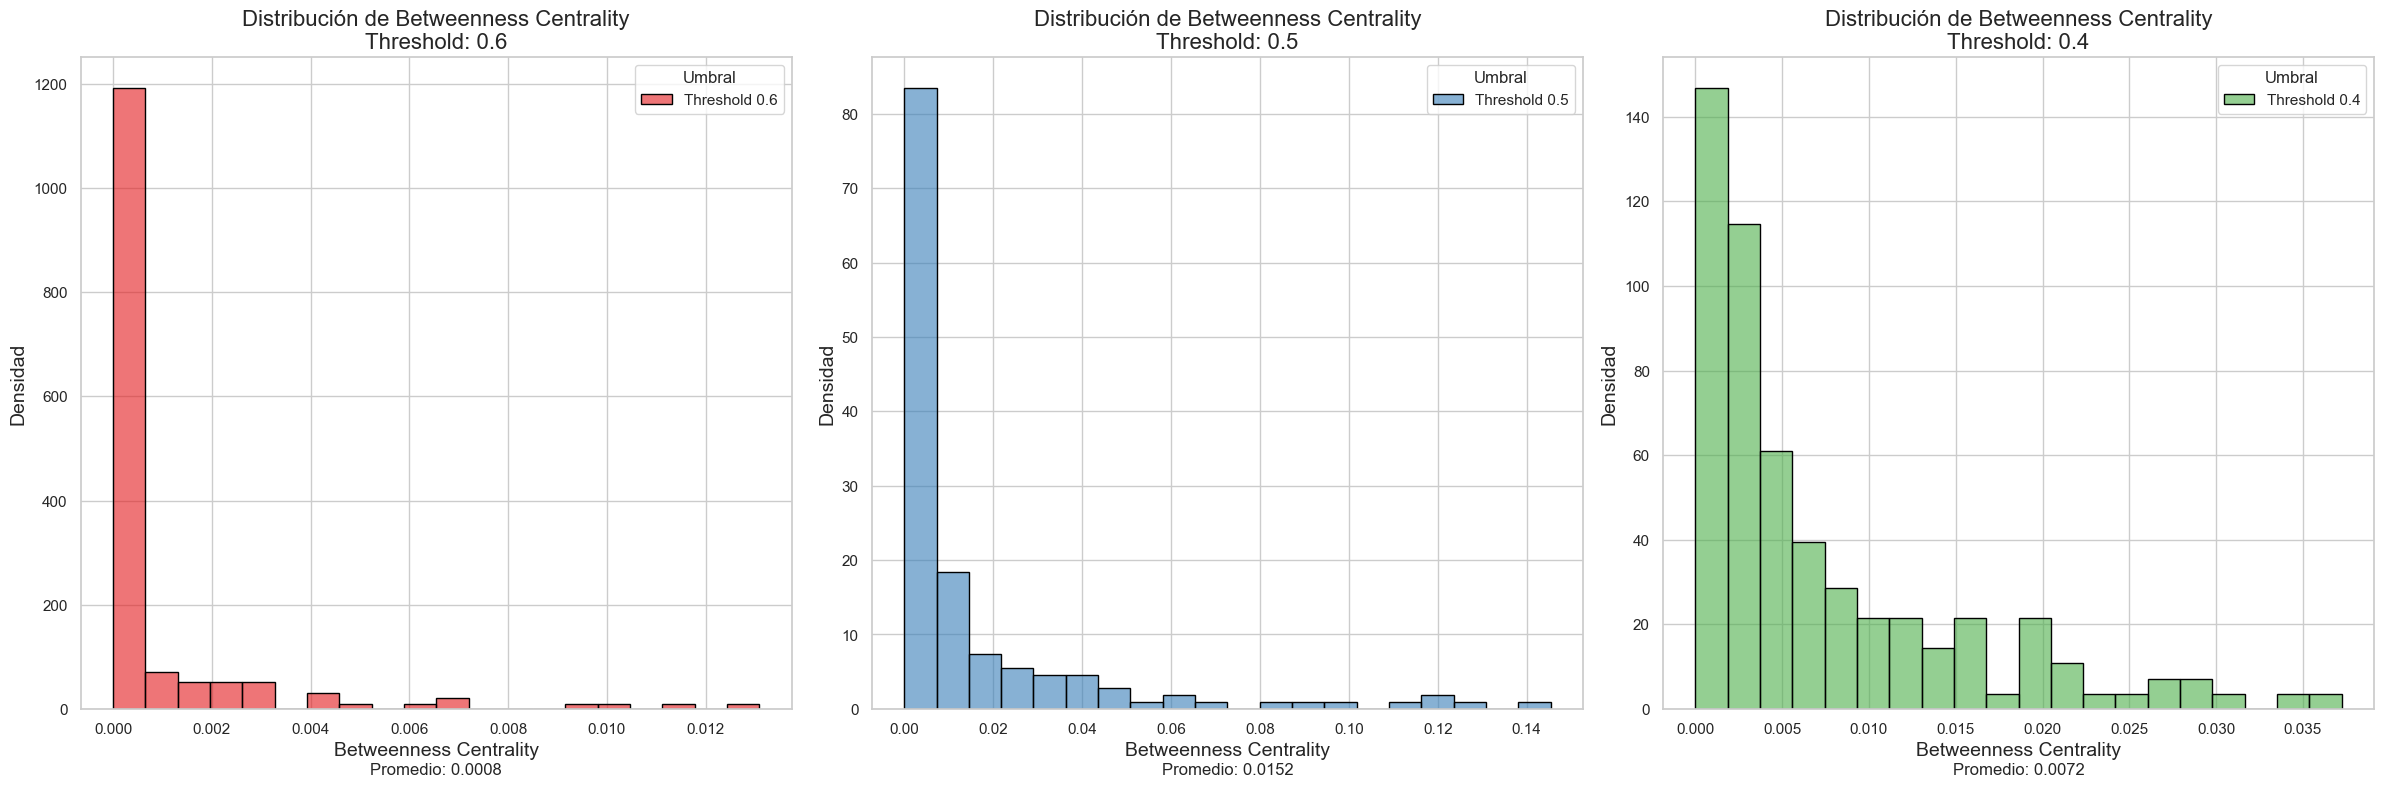

'"El betweenness centrality (centralidad de intermediación) mide la importancia de un nodo en una red con base en cuántos caminos más cortos entre pares de nodos pasan a través de él. En otras palabras, evalúa qué tan intermediario es un nodo en la conexión de otros nodos en la red.'

In [22]:
# Crear una nueva figura para la distribución de betweenness centrality de nodos con 3 subgráficos
fig_betweenness_nodes, axes_betweenness_nodes = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de betweenness centrality de nodos
for idx, (clave, G) in enumerate(grafos.items()):
    # Calcular el betweenness centrality para nodos
    betweenness_nodes = nx.betweenness_centrality(G)
    
    # Convertir a una serie de pandas para facilitar el manejo
    betweenness_series = pd.Series(betweenness_nodes)
    
    # Calcular el promedio de betweenness centrality
    promedio_betweenness = betweenness_series.mean()
    
    # Plotear el histograma de betweenness centrality de nodos en su propio subgráfico
    sns.histplot(
        betweenness_series, bins=20,
        kde=False, stat="density", label=f'Threshold {thresholds[clave]}',
        color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_betweenness_nodes[idx]
    )
    
    # Añadir título y etiquetas a cada subgráfico
    axes_betweenness_nodes[idx].set_title(
        f'Distribución de Betweenness Centrality\nThreshold: {thresholds[clave]}',
        fontsize=16
    )
    axes_betweenness_nodes[idx].set_xlabel('Betweenness Centrality', fontsize=14)
    axes_betweenness_nodes[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda y subtítulo con el promedio
    axes_betweenness_nodes[idx].legend(title='Umbral')
    axes_betweenness_nodes[idx].text(
        0.5, -0.1, f'Promedio: {promedio_betweenness:.4f}',
        fontsize=12, ha='center', transform=axes_betweenness_nodes[idx].transAxes
    )

# Ajustar el layout y mostrar la figura de la distribución de betweenness centrality
plt.tight_layout()
plt.show()

""""El betweenness centrality (centralidad de intermediación) mide la importancia de un nodo en una red con base en cuántos caminos más cortos entre pares de nodos pasan a través de él. En otras palabras, evalúa qué tan intermediario es un nodo en la conexión de otros nodos en la red."""


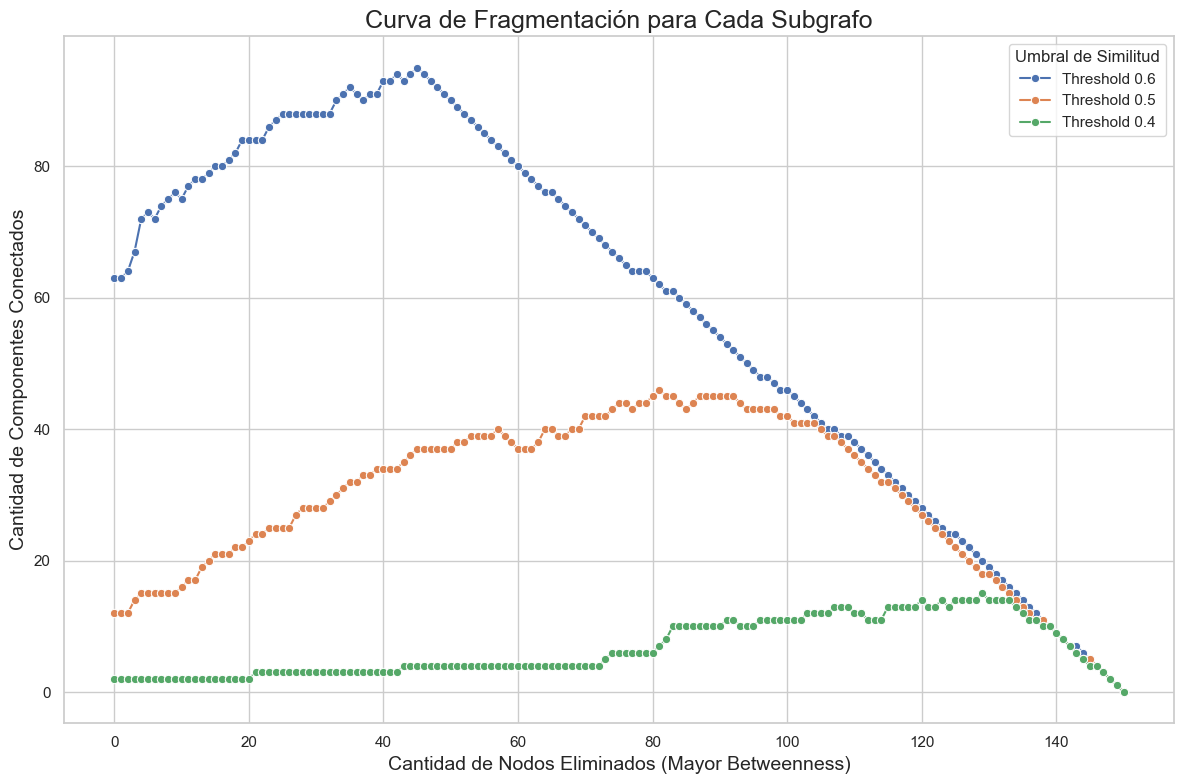

'"\nanalizamos cómo cambia la estructura de la red en función de la eliminación de nodos ordenados por alguna métrica (como la centralidad de intermediación), esto se evalúa mediante la curva de fragmentación o análisis de vulnerabilidad de la red.\nEste análisis refleja cómo la eliminación de nodos importantes afecta la conectividad general de la red.\n'

In [26]:
# ==========================================
# Paso 7: Generar la Curva de Fragmentación para cada subgrafo
# ==========================================

def generar_curva_fragmentacion(G, label=''):
    """
    Genera los datos y dibuja la Curva de Fragmentación para un grafo dado.
    
    Parameters:
    - G: networkx.Graph, el grafo para analizar.
    - label: str, etiqueta para la curva en el gráfico.
    
    Returns:
    - df_fragmentacion: pandas.DataFrame con los datos de la curva.
    """
    # Calcular la centralidad de intermediación (betweenness centrality)
    betweenness = nx.betweenness_centrality(G)
    # Ordenar los nodos por betweenness de mayor a menor
    nodos_ordenados = sorted(betweenness, key=betweenness.get, reverse=True)
    
    # Inicializar variables para la fragmentación
    componentes = []
    nodos_eliminados = []
    
    # Número inicial de componentes
    num_componentes = nx.number_connected_components(G)
    componentes.append(num_componentes)
    nodos_eliminados.append(0)
    
    # Crear una copia del grafo para eliminar nodos
    G_fragment = G.copy()
    
    # Iterar eliminando nodos por orden de betweenness
    for idx, nodo in enumerate(nodos_ordenados, 1):
        G_fragment.remove_node(nodo)
        current_num = nx.number_connected_components(G_fragment)
        componentes.append(current_num)
        nodos_eliminados.append(idx)
    
    # Crear el DataFrame para la Curva de Fragmentación
    df_fragmentacion = pd.DataFrame({
        'Nodos Eliminados': nodos_eliminados,
        'Número de Componentes': componentes
    })
    
    # Retornar el DataFrame y el label
    return df_fragmentacion, label

# ==========================================
# Paso 8: Graficar las Curvas de Fragmentación para todos los subgrafos
# ==========================================

plt.figure(figsize=(12, 8))

# Iterar sobre cada grafo y generar su curva de fragmentación
for clave, G in grafos.items():
    umbral = thresholds_ordenados[clave]
    label = f'Threshold {umbral}'
    df_fragmentacion, lbl = generar_curva_fragmentacion(G, label=label)
    sns.lineplot(data=df_fragmentacion, x='Nodos Eliminados', y='Número de Componentes', marker='o', label=lbl)

plt.title('Curva de Fragmentación para Cada Subgrafo', fontsize=18)
plt.xlabel('Cantidad de Nodos Eliminados (Mayor Betweenness)', fontsize=14)
plt.ylabel('Cantidad de Componentes Conectados', fontsize=14)
plt.legend(title='Umbral de Similitud')
plt.grid(True)
plt.tight_layout()
plt.show()

""""
analizamos cómo cambia la estructura de la red en función de la eliminación de nodos ordenados por alguna métrica (como la centralidad de intermediación), esto se evalúa mediante la curva de fragmentación o análisis de vulnerabilidad de la red.
Este análisis refleja cómo la eliminación de nodos importantes afecta la conectividad general de la red.
"""
